# Ejercicio PCA (Principal Component Analysis)
En este ejercicio vas a trabajar con un dataset de información de ciudadanos como el estado civil, número de hijos, qué gastos e ingresos tiene, etc...

Se cuenta con un target, que es si el ciudadano va a alquilar o a comprar una vivienda. Para ello,  con PCA

### Importamos librerias
Principales librerías que usarás durante el notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
sns.set(style="whitegrid")

### Cargamos datos de entrada
1. Carga el csv *comprar_alquilar.csv*
2. Obtén la información básica: columnas, dimensiones, descripción de las variables, missings...

In [2]:
df = pd.read_csv('data/comprar_alquilar.csv')

print("Dimensiones del DataFrame:", df.shape)
print("\nInformación del DataFrame:")
print(df.info())

print("\nPrimeras 5 filas del DataFrame:")
print(df.head())

print("\nEstadísticas descriptivas:")
print(df.describe())

print("\nValores nulos por columna:")
print(df.isnull().sum())

print("\nDistribución de la variable target (comprar):")
print(df['comprar'].value_counts())
print(df['comprar'].value_counts(normalize=True).map('{:.1%}'.format))

Dimensiones del DataFrame: (202, 10)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ingresos        202 non-null    int64
 1   gastos_comunes  202 non-null    int64
 2   pago_coche      202 non-null    int64
 3   gastos_otros    202 non-null    int64
 4   ahorros         202 non-null    int64
 5   vivienda        202 non-null    int64
 6   estado_civil    202 non-null    int64
 7   hijos           202 non-null    int64
 8   trabajo         202 non-null    int64
 9   comprar         202 non-null    int64
dtypes: int64(10)
memory usage: 15.9 KB
None

Primeras 5 filas del DataFrame:
   ingresos  gastos_comunes  pago_coche  gastos_otros  ahorros  vivienda  \
0      6000            1000           0           600    50000    400000   
1      6745             944         123           429    43240    636897   
2      6

### Visualicemos las dimensiones
Realiza un análisis univariante. Realiza la gráfica que consideres para cada variable, diferenciando por colores el target (*comprar*).

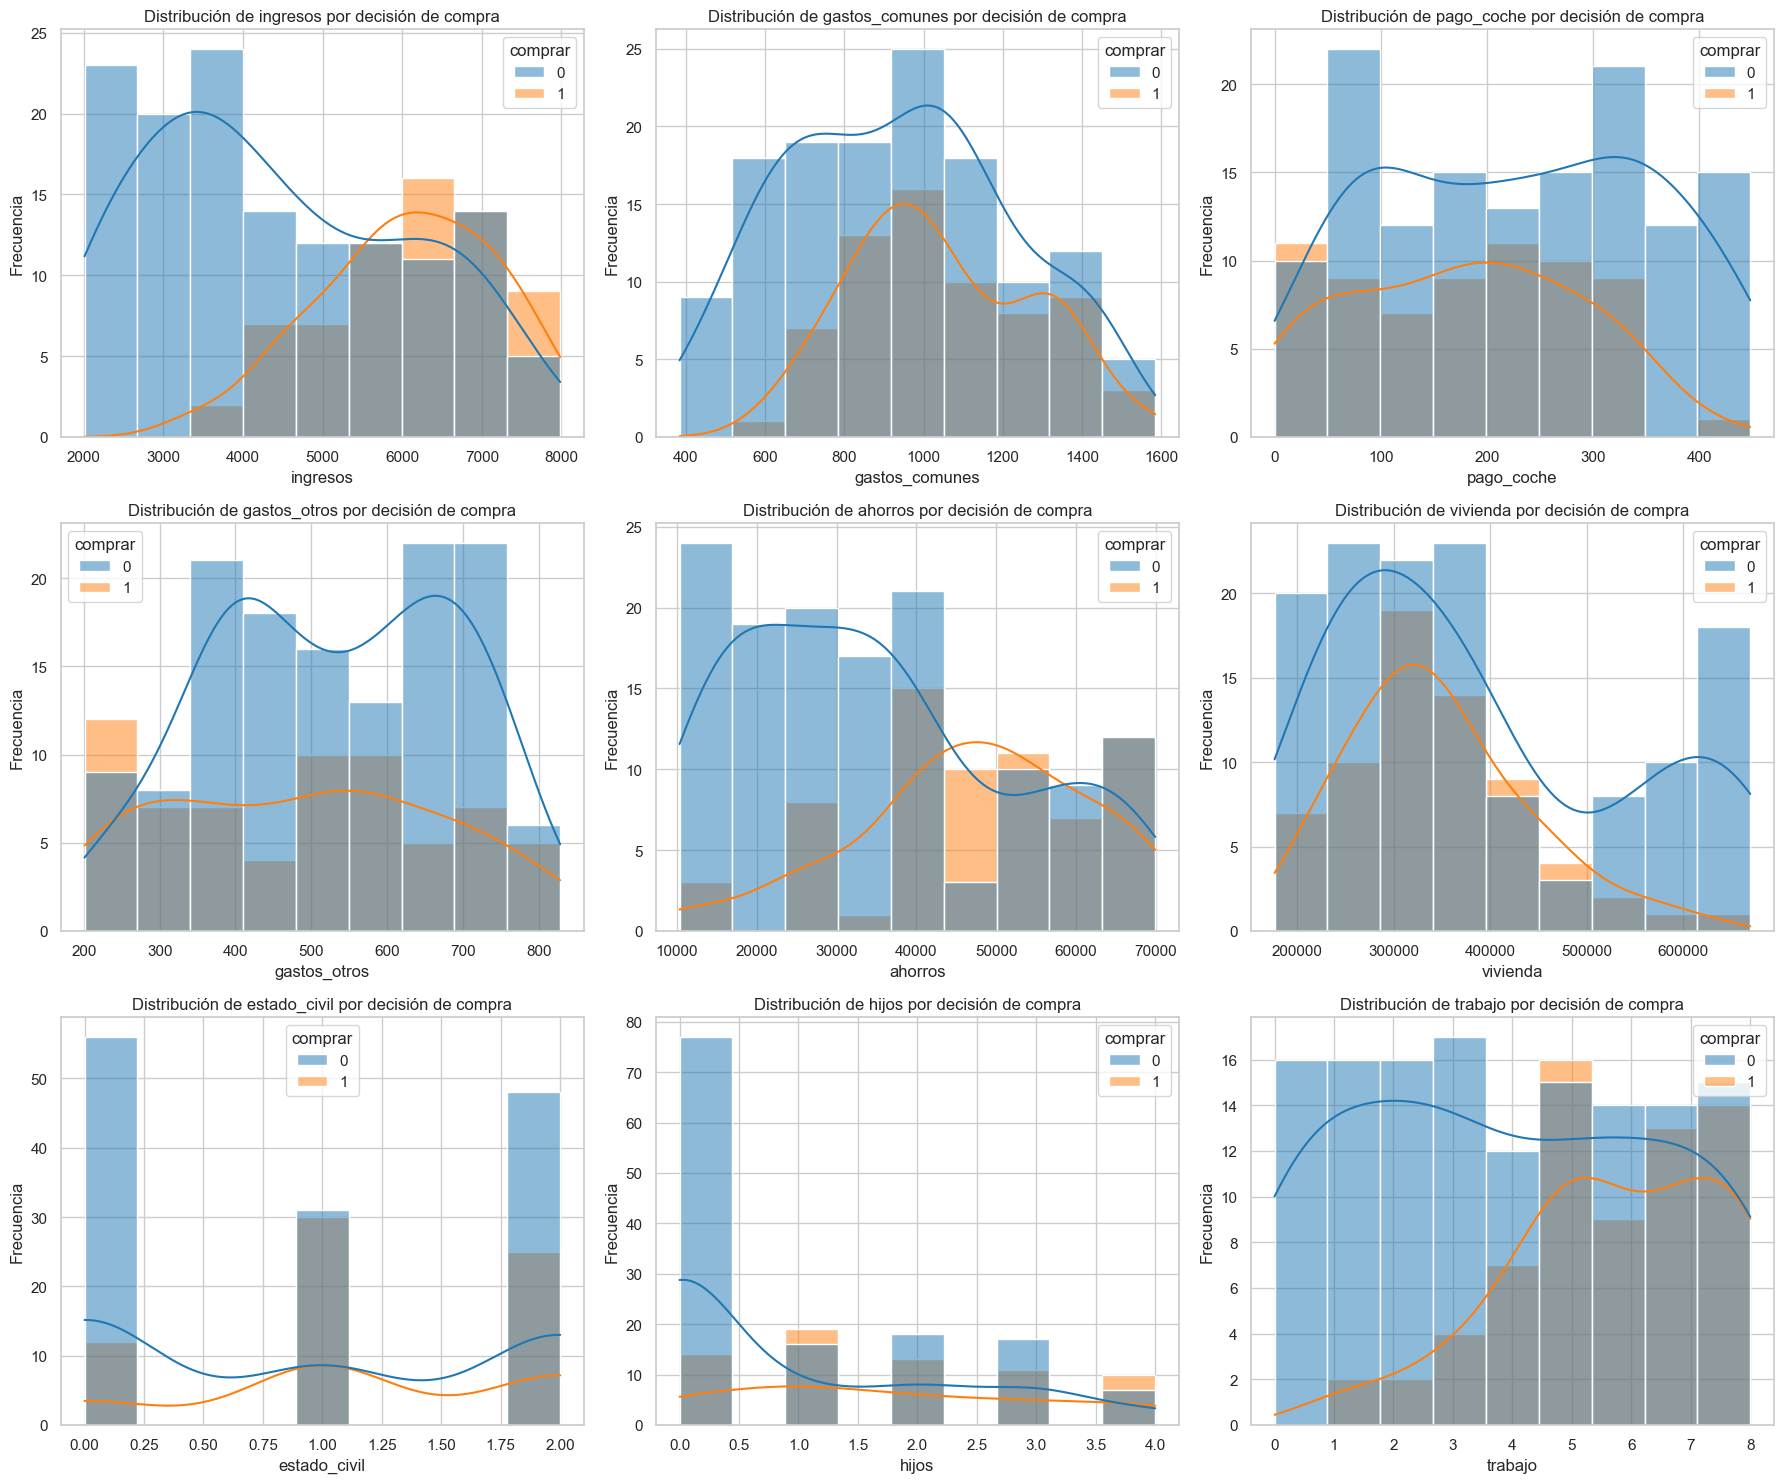

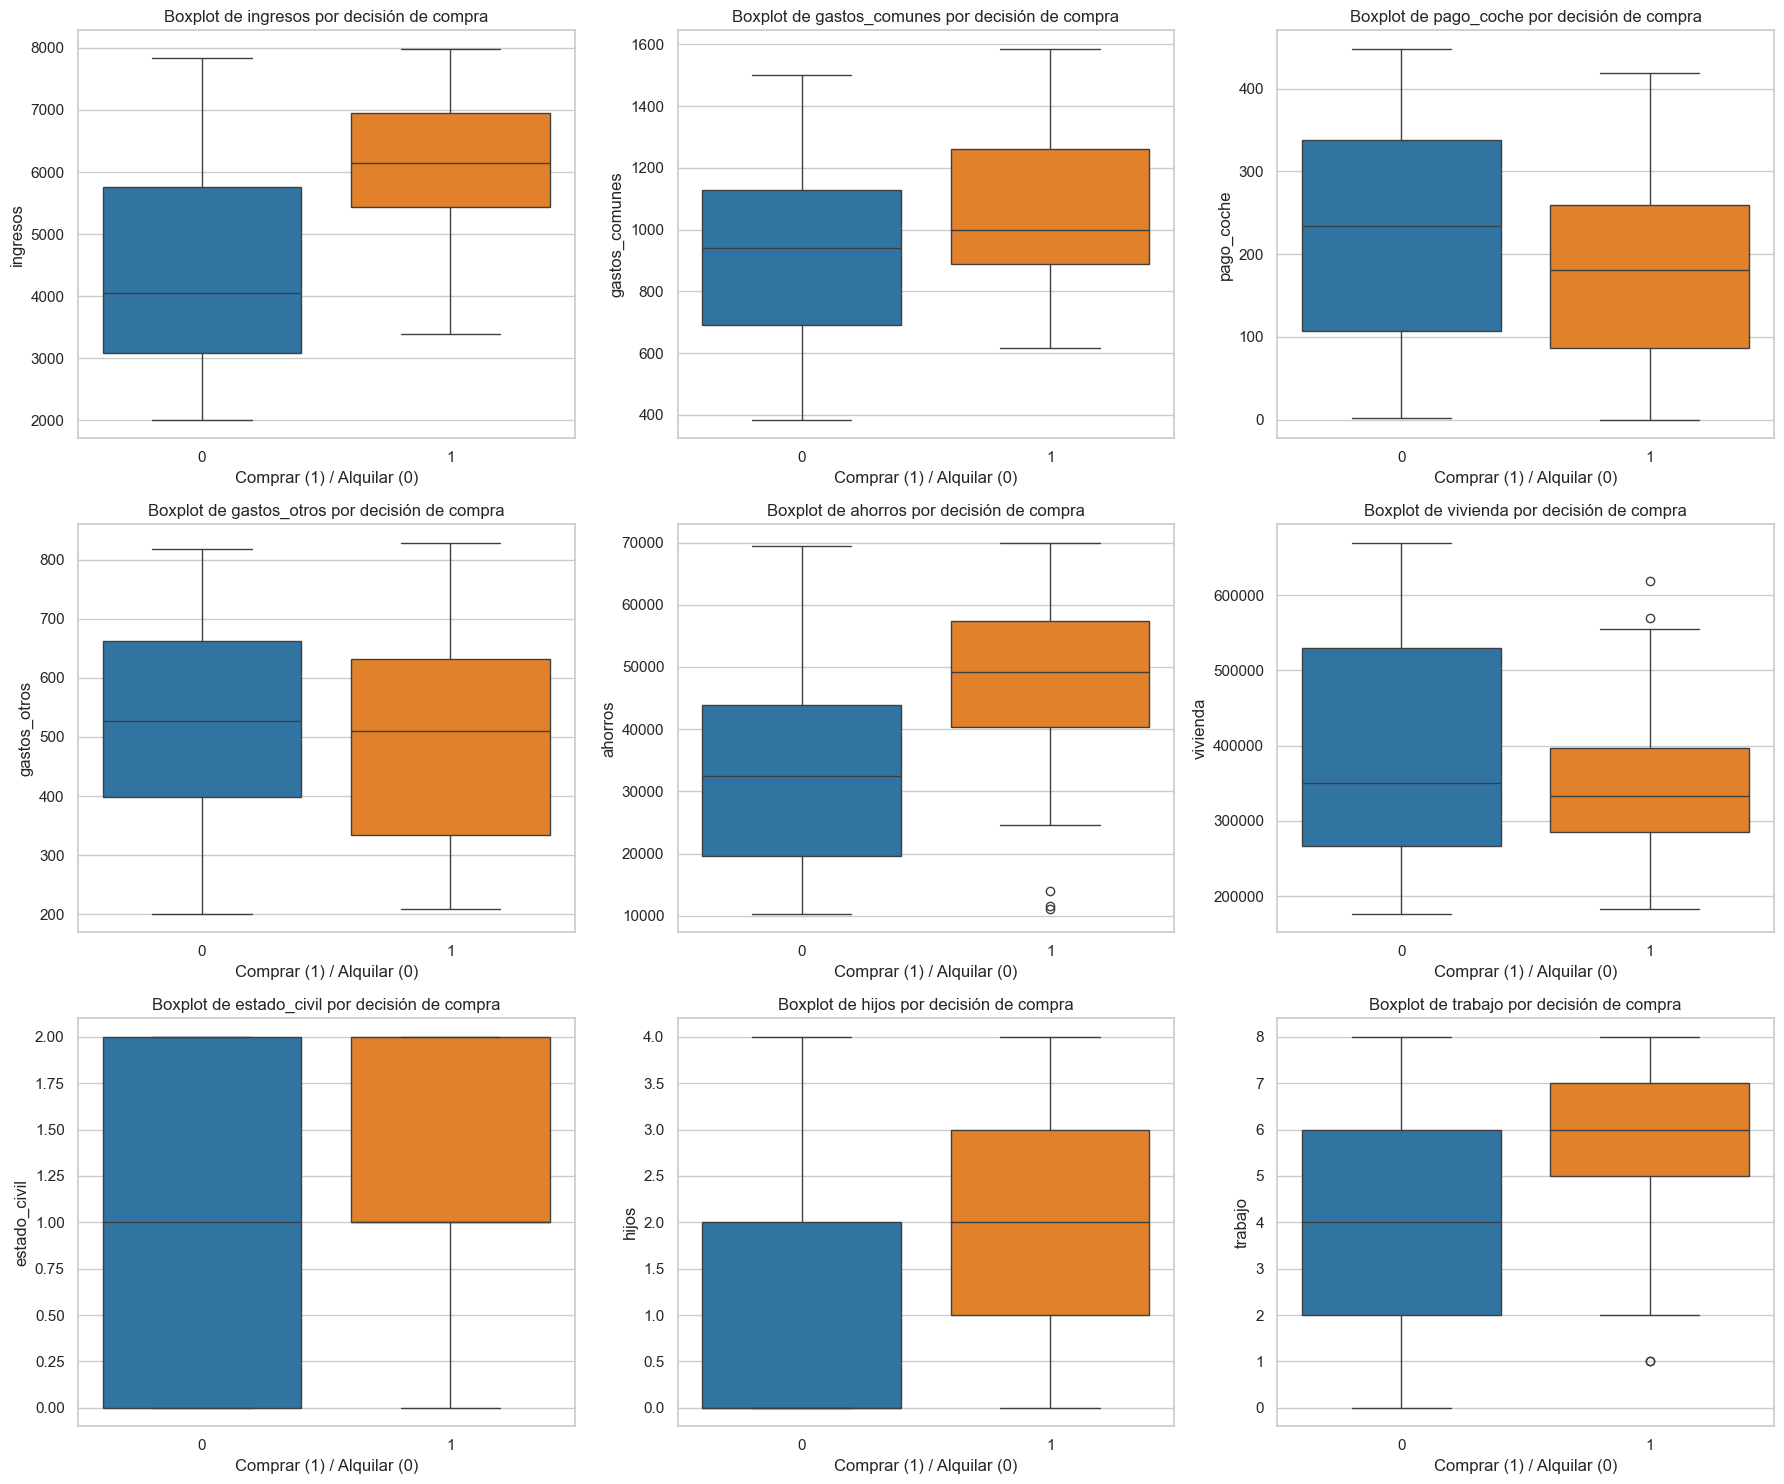

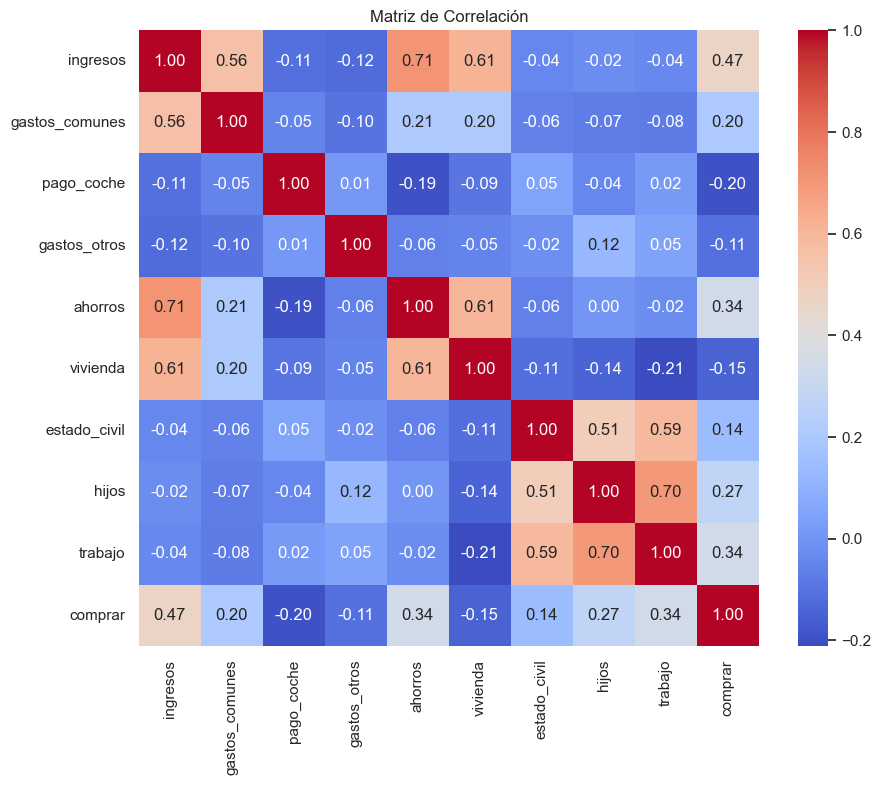

In [3]:
colors = ['#1f77b4', '#ff7f0e']

fig, axs = plt.subplots(3, 3, figsize=(18, 15))
axs = axs.flatten()

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.drop('comprar')

for i, column in enumerate(numeric_columns):
    if i < len(axs):  
        sns.histplot(data=df, x=column, hue='comprar', ax=axs[i], kde=True, palette=colors)
        axs[i].set_title(f'Distribución de {column} por decisión de compra')
        axs[i].set_xlabel(column)
        axs[i].set_ylabel('Frecuencia')

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 3, figsize=(18, 15))
axs = axs.flatten()

for i, column in enumerate(numeric_columns):
    if i < len(axs):
        sns.boxplot(data=df, x='comprar', y=column, ax=axs[i], palette=colors)
        axs[i].set_title(f'Boxplot de {column} por decisión de compra')
        axs[i].set_xlabel('Comprar (1) / Alquilar (0)')
        axs[i].set_ylabel(column)

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

## Estandariza los datos
Como el objetivo de estos primeros apartados no es encontrar el mejor modelo con el mejor accuracy, por sencillez, no es necesario dividir en train y test.

In [4]:
X = df.drop('comprar', axis=1)
y = df['comprar']

feature_names = X.columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)
print("Estadísticas descriptivas después de la estandarización:")
print(X_scaled_df.describe())

Estadísticas descriptivas después de la estandarización:
           ingresos  gastos_comunes    pago_coche  gastos_otros       ahorros  \
count  2.020000e+02    2.020000e+02  2.020000e+02  2.020000e+02  2.020000e+02   
mean  -1.319077e-16    9.013692e-17  1.143200e-16 -2.462277e-16  8.903769e-17   
std    1.002484e+00    1.002484e+00  1.002484e+00  1.002484e+00  1.002484e+00   
min   -1.757913e+00   -2.164757e+00 -1.698954e+00 -1.875081e+00 -1.641286e+00   
25%   -8.609353e-01   -7.546427e-01 -9.046102e-01 -7.882314e-01 -7.958240e-01   
50%   -6.847623e-03   -1.320463e-02 -2.601737e-02  4.218741e-02 -1.308543e-02   
75%    8.432190e-01    7.134968e-01  8.585932e-01  8.427887e-01  7.736365e-01   
max    1.802001e+00    2.259925e+00  1.895654e+00  1.864040e+00  1.800253e+00   

           vivienda  estado_civil         hijos       trabajo  
count  2.020000e+02  2.020000e+02  2.020000e+02  2.020000e+02  
mean  -1.121215e-16 -2.198461e-18  1.758769e-17  3.627461e-17  
std    1.002484e+00  

## Aplicamos PCA
Aplica el algoritmo de PCA para 9 components, es decir, para todas las features

In [5]:
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(
    data=X_pca,
    columns=[f'PC{i+1}' for i in range(9)]
)

print("Primeras filas del DataFrame con componentes principales:")
print(pca_df.head())

Primeras filas del DataFrame con componentes principales:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.321915 -0.222950  1.599863 -0.885014  0.646617 -0.700208  0.318031   
1  1.147878  1.716967  0.395722 -0.447960 -0.687805 -0.231969  1.542487   
2  0.090369  1.836066  1.359382  0.337505  0.742387  0.593030 -1.540495   
3  3.455898 -0.078279 -0.202382 -1.573584 -0.068551 -0.051945  0.909409   
4  0.916933 -1.184676  0.190036  0.117804 -0.147753 -0.619750 -0.450419   

        PC8       PC9  
0 -0.751809  0.269984  
1  0.221799  0.438425  
2  0.668120  0.153463  
3  0.684486 -0.129045  
4  0.194341  0.687452  


### Veamos cómo de buenos predictores son las nuevas dimensiones
Responde a las siguientes preguntas:
1. ¿Cuánta varianza explica cada Principal Component?
2. ¿Y de manera acumulada empezando por el PC1?
3. ¿Cuánta varianza explicarían sólo 5 componentes?

In [7]:

# 1. Varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente principal:")
for i, variance in enumerate(explained_variance):
    print(f"PC{i+1}: {variance:.4f} ({variance*100:.2f}%)")

# 2. Varianza acumulada
cumulative_variance = np.cumsum(explained_variance)
print("\nVarianza acumulada:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"PC1 a PC{i+1}: {cum_var:.4f} ({cum_var*100:.2f}%)")

# 3. Varianza explicada por 5 componentes
variance_5_components = sum(explained_variance[:5])
print(f"\nVarianza explicada por los primeros 5 componentes: {variance_5_components:.4f} ({variance_5_components*100:.2f}%)")

Varianza explicada por cada componente principal:
PC1: 0.2991 (29.91%)
PC2: 0.2329 (23.29%)
PC3: 0.1171 (11.71%)
PC4: 0.1069 (10.69%)
PC5: 0.0964 (9.64%)
PC6: 0.0563 (5.63%)
PC7: 0.0415 (4.15%)
PC8: 0.0302 (3.02%)
PC9: 0.0197 (1.97%)

Varianza acumulada:
PC1 a PC1: 0.2991 (29.91%)
PC1 a PC2: 0.5321 (53.21%)
PC1 a PC3: 0.6492 (64.92%)
PC1 a PC4: 0.7561 (75.61%)
PC1 a PC5: 0.8524 (85.24%)
PC1 a PC6: 0.9087 (90.87%)
PC1 a PC7: 0.9502 (95.02%)
PC1 a PC8: 0.9803 (98.03%)
PC1 a PC9: 1.0000 (100.00%)

Varianza explicada por los primeros 5 componentes: 0.8524 (85.24%)


### Graficamos la variacion explicada acumulada
Representa en un diagrama de lineas la evolución de la varianza acumulada en función de los PC

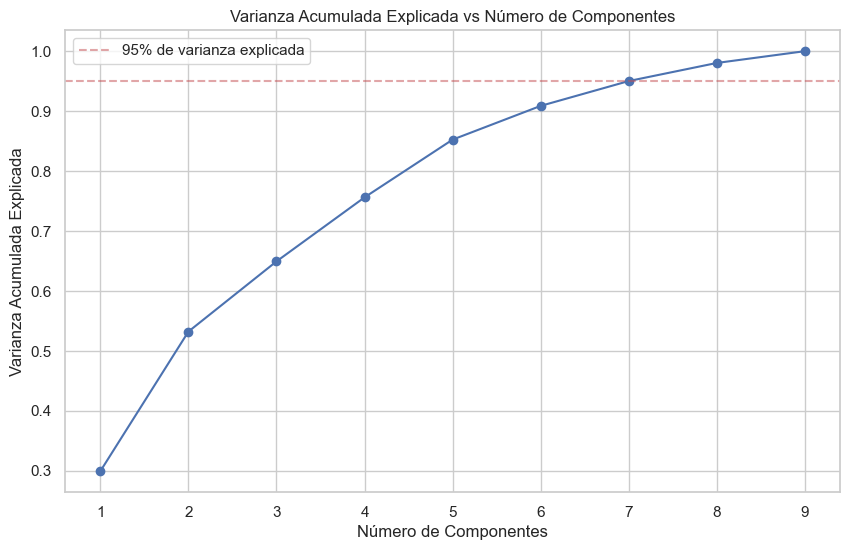

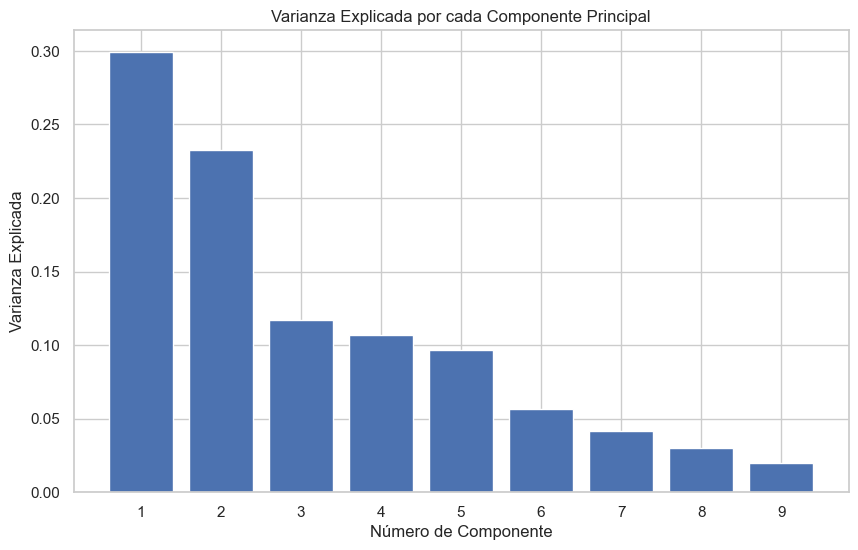

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='95% de varianza explicada')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Varianza Acumulada Explicada vs Número de Componentes')
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Número de Componente')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por cada Componente Principal')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

### Veamos la correlación entre las nuevas componentes y las dimensiones originales
Representa en un mapa de calor los PCA vs las variables originales. Esta información la puedes obtener del atributo de PCA *components_*.

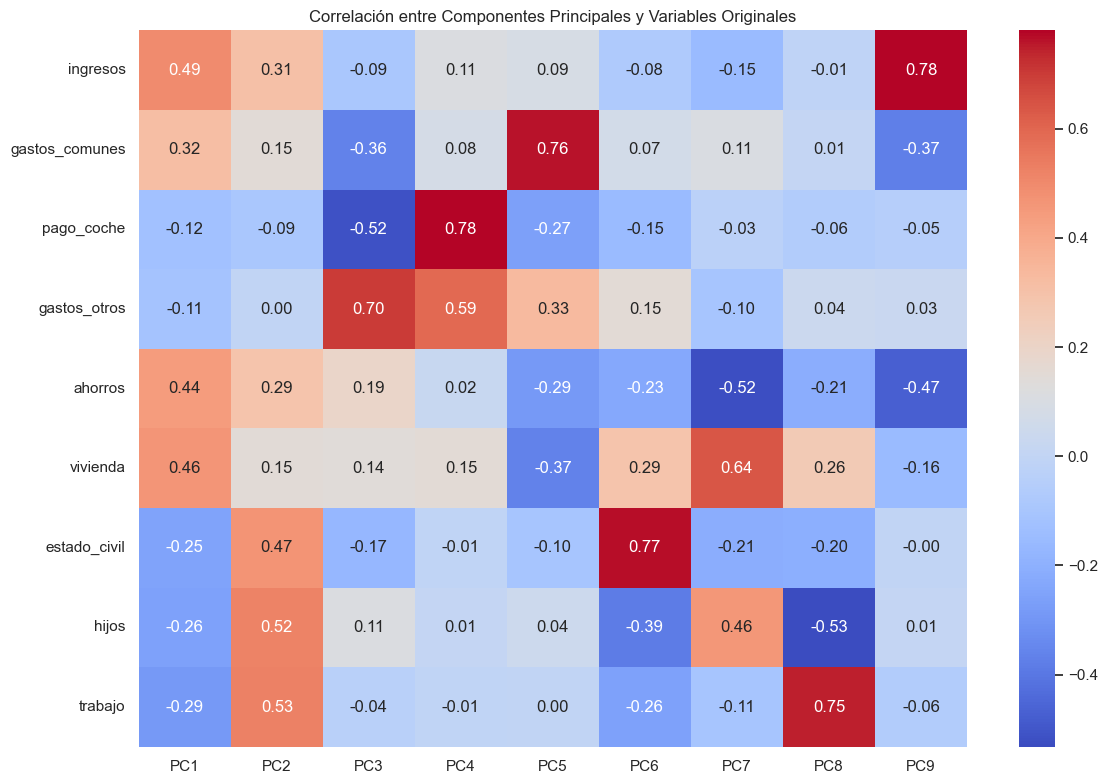

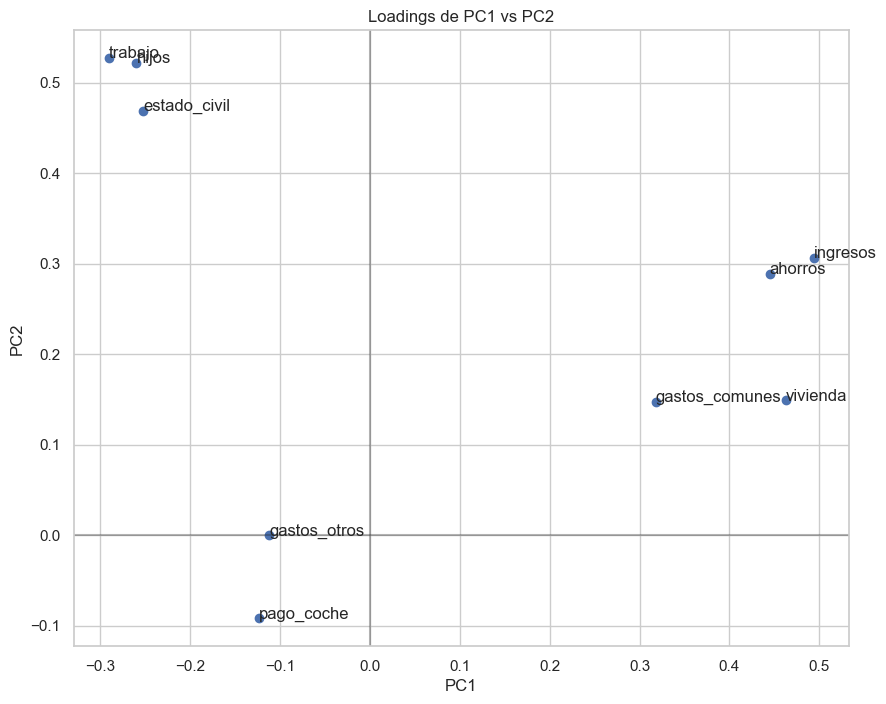

In [9]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(9)],
    index=feature_names
)

plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre Componentes Principales y Variables Originales')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(loadings.iloc[:, 0], loadings.iloc[:, 1])
for i, feature in enumerate(feature_names):
    plt.annotate(feature, (loadings.iloc[i, 0], loadings.iloc[i, 1]))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Loadings de PC1 vs PC2')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.show()

## Predicciones
1. Divide en train y test
2. Prepara un pipeline compuesto por:
    - StandardScaler,
    - PCA de 5 componentes
    - Un clasificador
3. Entrena
4. Predice con test
5. Calcula el accuracy score en train y test
6. Representa la matriz de confusión
7. ¿Qué combinación de parámetros y componentes mejoraría el accuracy en test?
8. Vuelve a iterar de nuevo con un gridsearch
9. Guarda tu mejor modelo

Accuracy en train: 1.0000
Accuracy en test: 0.7541


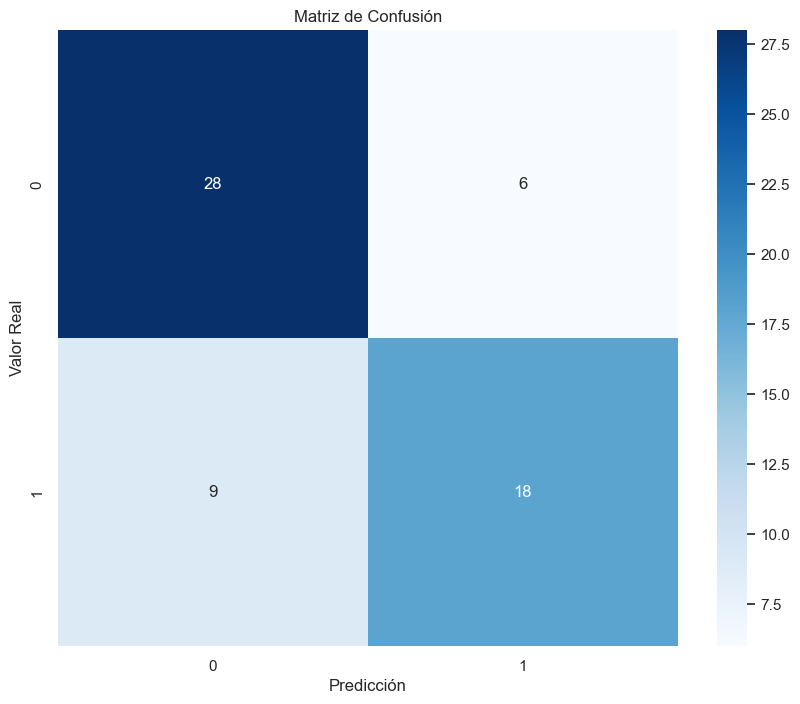


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79        34
           1       0.75      0.67      0.71        27

    accuracy                           0.75        61
   macro avg       0.75      0.75      0.75        61
weighted avg       0.75      0.75      0.75        61



In [10]:
# 1. Dividimos en train y test (70% - 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Preparamos el pipeline con StandardScaler, PCA y un clasificador (Random Forest)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 3. Entrenamos el modelo
pipeline.fit(X_train, y_train)

# 4. Realizamos predicciones
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# 5. Calculamos el accuracy en train y test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Accuracy en train: {train_accuracy:.4f}")
print(f"Accuracy en test: {test_accuracy:.4f}")

# 6. Visualizamos la matriz de confusión
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Mostrar reporte de clasificación
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_test_pred))